In [1]:
# Install dependencies
!pip install torch-geometric
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.1+cu116.html


Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html


In [2]:
# Import dependencies, check versions
import torch_geometric
import pandas as pd
import torch
import os
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
# And some typing for code completion
from typing import Dict, List, Tuple, Union, Optional

print(torch.__version__)
print(torch_geometric.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on", device)

"""
Should be:
1.13.1
2.2.0
"""
pass


1.13.1
2.2.0
Running on cuda


In [3]:
# Dataset location
os.environ['DATASET_PATH'] = r'D:/Documents/FAKS/3. LETNIK/MLG/project-final/elliptic_bitcoin_dataset' # Uncomment this to add own path
is_running_from_local = 'DATASET_PATH' in os.environ
if is_running_from_local:
    print('DATA_PATH: ', os.environ['DATASET_PATH'])
    DATASET_PATH = os.environ['DATASET_PATH']
else:
    from google.colab import drive
    drive.mount('/content/drive')  # Check: !ls drive/MyDrive/
    DATASET_PATH = 'drive/MyDrive/elliptic_bitcoin_dataset/'
    print("Reading from Google Colab")
    print('DATA_PATH: ', DATASET_PATH)


DATA_PATH:  C:\Faks\MLG\MLGproject\dataset\elliptic_bitcoin_dataset


In [4]:
# Reading data to DataFrames
classes = pd.read_csv(
    f"{DATASET_PATH}/elliptic_txs_classes.csv", index_col="txId")
edgelist = pd.read_csv(
    f"{DATASET_PATH}/elliptic_txs_edgelist.csv")

# index is on top level timestamp, second level txId
features = pd.read_csv(
    f"{DATASET_PATH}/elliptic_txs_features.csv", header=None, index_col=[1, 0])
features.index.names = ['timestamp', 'txId']

# That way, features are sorted by timestamp, as sample of first 5 columns shows:
display(features.loc[:, :5])

# TODO! Feature statistic/normalization

2         3         4          5
timestamp txId                                              
1         230425980 -0.171469 -0.184668 -1.201369  -0.121970
          5530458   -0.171484 -0.184668 -1.201369  -0.121970
          232022460 -0.172107 -0.184668 -1.201369  -0.121970
          232438397  0.163054  1.963790 -0.646376  12.409294
          230460314  1.011523 -0.081127 -1.201369   1.153668
...                       ...       ...       ...        ...
49        173077460 -0.145771 -0.163752  0.463609  -0.121970
          158577750 -0.165920 -0.123607  1.018602  -0.121970
          158375402 -0.172014 -0.078182  1.018602   0.028105
          158654197 -0.172842 -0.176622  1.018602  -0.121970
          157597225 -0.012037 -0.132276  0.463609  -0.121970

[203769 rows x 4 columns]

In [5]:
# Defining target classes
# Initial graph should be directed
directed_graph = nx.from_pandas_edgelist(
    edgelist, source='txId1', target='txId2', create_using=nx.DiGraph())
print(f"{nx.is_directed(directed_graph)=}")


ID_ILLICIT = 0  # Fraud
ID_LICIT = 1  # Legiet
ID_UNLABELED = 2 # Unknown

classes['y'] = classes['class'].replace(
    {'unknown': ID_UNLABELED, '1': ID_ILLICIT, '2': ID_LICIT})
class_mapping = classes[['y']].to_dict("dict")['y']

keys = features.index.get_level_values(1)
rows = torch.tensor(features.values, dtype=torch.double, device=device)
feature_mapping = dict(zip(keys, rows))


nx.is_directed(directed_graph)=True


In [6]:
# Subgraph splitting
timestamps = features.index.get_level_values(
    0).unique().sort_values().to_list()
ts_Tid_df = features.index.to_frame(index=False)
dataset = []
for ts in timestamps:
    # Get all txIds for a given timestamp
    sub_graph_idx = ts_Tid_df[ts_Tid_df.timestamp == ts].txId.to_list()
    # Create subgraph from the original graph
    s = directed_graph.subgraph(sub_graph_idx)
    nx.set_node_attributes(s, class_mapping, "y")
    nx.set_node_attributes(s, feature_mapping, "x")

    dataset.append(s)

# Takes ~20sec to run


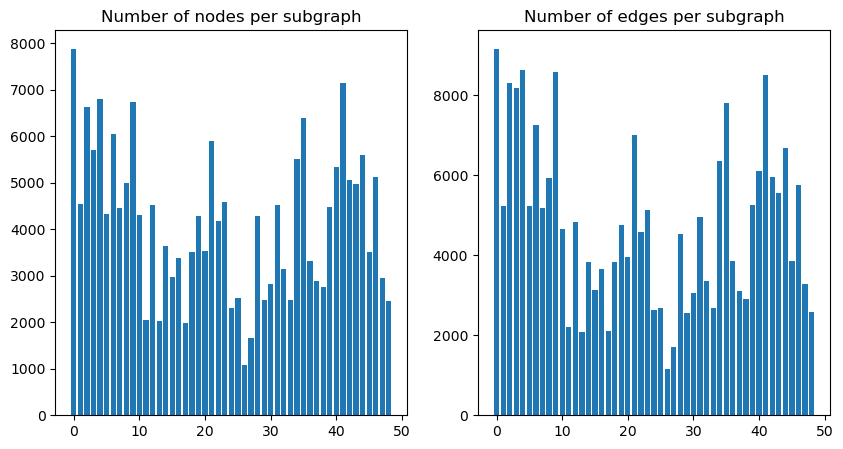

In [7]:
# Vertex/Edge count
node_counter = np.array([len(subgraph.nodes) for subgraph in dataset])
edge_counter = np.array([len(subgraph.edges) for subgraph in dataset])

# TODO! Use seaborn?
# Plotting bar plots
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(np.arange(len(node_counter)), node_counter)
plt.title("Number of nodes per subgraph")

plt.subplot(1, 2, 2)
plt.bar(np.arange(len(edge_counter)), edge_counter)
plt.title("Number of edges per subgraph")

plt.show()


In [8]:
# Displaying the smallest subgraph
min_vertecies_idx = np.argmin(node_counter)
smallest_subgraph = dataset[min_vertecies_idx]

color_map = {ID_UNLABELED: "grey", ID_LICIT: "green", ID_ILLICIT: "red"}
colors = [color_map[attrs["y"]] for _, attrs in smallest_subgraph.nodes(data=True)]
nx.draw(smallest_subgraph, node_color=colors, node_size=4)


TypeError: '_AxesStack' object is not callable

<Figure size 640x480 with 0 Axes>

In [115]:
# Model definition
from torch_geometric.nn import GCNConv, GATConv, BatchNorm
import torch.nn as nn
import torch.nn.functional as F


class SM2_GCN(torch.nn.Module):
    def __init__(self,
                 in_channels: int,
                 hidden_channels: int,
                 out_channels: int,
                 conv_model: type[nn.Module],
                 nonlinearity: nn.Module,
                 num_hidden: int = 3,
                 conv_args: Dict = {},
                 dropout: float = 0.5):
        super(SM2_GCN, self).__init__()

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        self.convs.append(
            conv_model(in_channels, hidden_channels, **conv_args)
        )
        self.bns.append(BatchNorm(hidden_channels))
        for _ in range(num_hidden):  # TODO!: BatchNorm or LayerNorm?
            self.convs.append(
                conv_model(hidden_channels, hidden_channels, **conv_args))
            self.bns.append(BatchNorm(hidden_channels))

        self.convs.append(
            conv_model(hidden_channels, out_channels, **conv_args))
        self.bns.append(BatchNorm(hidden_channels))

        self.dropout = dropout
        self.nonlinearity = nonlinearity

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            # TODO! Check dimensionality of x after GCNConv and GATConv
            x = self.nonlinearity(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if i < len(self.convs) - 1:
                x = self.bns[i](x)
        return x


In [116]:
# Testing Config
from dataclasses import dataclass, asdict, field
import json
import re


@dataclass
class TrainConfig:
    num_epoch: int = 10
    batch_size: int = 32
    test_split: float = 0.2
    random_state: Optional[int] = None

    # Optimizer
    optimizer_name: str = 'adam'
    lr: float = 0.01
    weight_decay: float = 5e-4

    def get_optimizer_for(self, model):
        if self.optimizer_name == 'adam':
            return torch.optim.Adam(model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        elif self.optimizer_name == 'sgd':
            return torch.optim.SGD(model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        else:
            raise ValueError(f"Unknown optimizer name: {self.optimizer_name}")

    # Loss
    loss_name: str = 'cross_entropy'

    def get_loss(self):
        if self.loss_name == 'cross_entropy':
            return torch.nn.CrossEntropyLoss()
        if self.loss_name == 'bce':
            return torch.nn.BCEWithLogitsLoss()
        else:
            raise ValueError(f"Unknown loss name: {self.loss_name}")

    @classmethod
    def load(cls, fname: str):
        with open(fname) as f:
            return cls(**json.load(f))

    def save(self, fname: str):
        with open(fname, 'w') as f:
            json.dump(asdict(self), f, indent=4)
        return self



In [117]:
# Data loaders
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx
from sklearn.model_selection import train_test_split


def get_data_loaders(config: TrainConfig, dataset: List[nx.Graph]):
    X_graphs = []
    for subgraph in dataset:
        _x = from_networkx(subgraph)
        _x.x = _x.x.to(device)
        _x.y = _x.y.to(device)
        X_graphs.append(_x)
    X_train, X_test = train_test_split(
        X_graphs, test_size=config.test_split, random_state=config.random_state)
    # TODO! Decide on validation/K-fold split
    train_loader = DataLoader(
        X_train, batch_size=config.batch_size, shuffle=True)
    test_loader = DataLoader(X_test, batch_size=1, shuffle=False)
    return train_loader, test_loader


In [118]:
# Train
from tqdm.notebook import trange, tqdm


def train(model: SM2_GCN, data_loader: DataLoader, config: TrainConfig):
    dataset = data_loader.dataset
    loss_fn = config.get_loss()
    optimizer = config.get_optimizer_for(model)
    model.to(device)
    model.reset_parameters()
    model.train()
    for epoch in trange(config.num_epoch, unit="Epochs", desc="Training"):
        epoch_loss = 0
        # TODO! Per-epoch check and save best model - refernce in colab
        for batch in data_loader:
            batch.to(device)
            out = model(batch.x.float(), batch.edge_index)
            labeled_mask = (batch.y != ID_UNLABELED)
            loss = loss_fn(out[labeled_mask],
                           batch.y[labeled_mask])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * batch.num_graphs
        avg_epoch_loss = epoch_loss / len(dataset)
        print(f"Epoch {epoch}, Loss: {avg_epoch_loss:.4f}")


In [119]:
# Test
from sklearn.metrics import accuracy_score, f1_score


def test(model: nn.Module, data_loader: DataLoader):
    model.eval()
    with torch.no_grad():
        for batch in tqdm(data_loader, unit="Test cases", desc="Testing"):
            batch.to(device)
            out = model(batch.x.float(), batch.edge_index)
            consideration_index = batch.y != ID_UNLABELED
            pred = out[consideration_index].max(dim=1)[1].cpu().numpy()
            y = batch.y[consideration_index].cpu().numpy()
            acc = accuracy_score(y, pred)
            f1 = f1_score(y, pred, average="macro") # TODO! micro or macro?
            print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}")


In [120]:
# Model Config

@dataclass
class ModelConfig:
    in_channels: int = -1
    hidden_channels: int = 64
    out_channels: int = 2
    num_hidden: int = 3
    conv_model: str = "GATConv"
    conv_args: dict = field(default_factory=dict)
    dropout: float = 0.5
    nonlinearity: str = 'leaky_relu(0.2)'

    def __nonlinearity(self):
        if self.nonlinearity == 'relu':
            return nn.ReLU()
        m = re.match(r'leaky_relu\((\d+\.?\d*)\)', self.nonlinearity)
        if m:
            return nn.LeakyReLU(float(m.group(1)))
        else:
            raise ValueError(f"Unknown nonlinearity: {self.nonlinearity}")

    def __model_type(self):
        if self.conv_model == "GATConv":
            return GATConv
        elif self.conv_model == "GCNConv":
            return GCNConv
        else:
            raise ValueError(f"Unknown model type: {self.conv_model}")

    def create(self):
        return SM2_GCN(in_channels=self.in_channels,
                       hidden_channels=self.hidden_channels,
                       out_channels=self.out_channels,
                       num_hidden=self.num_hidden,
                       conv_model=self.__model_type(),
                       conv_args=self.conv_args, dropout=self.dropout,
                       nonlinearity=self.__nonlinearity()
                )

    @classmethod
    def load(cls, fname: str):
        with open(fname) as f:
            return cls(**json.load(f))

    def save(self, fname: str):
        with open(fname, 'w') as f:
            json.dump(asdict(self), f, indent=4)
        return self


In [121]:
# All together now


fname = 'local_training_config.json'
try:
    config = TrainConfig.load(fname)
except FileNotFoundError:
    config = TrainConfig(
        num_epoch=10,
        batch_size=32,
        test_split=0.2,
        optimizer_name='adam',
        lr=0.01,
        weight_decay=5e-4,
        loss_name='cross_entropy'
    ).save(fname)

fname = 'local_model_config.json'
try:
    model_config = ModelConfig.load(fname)
except FileNotFoundError:
    model_config = ModelConfig(
        hidden_channels=64,
        num_hidden=3,
        conv_model='GATConv', conv_args={
            'heads': 4, 'concat': True},
        dropout=0.5,
        nonlinearity='leaky_relu(0.2)').save(fname)

model = model_config.create()
train_loader, test_loader = get_data_loaders(config, dataset)
train(model, train_loader, config)
test(model, test_loader)


Training:   0%|          | 0/100 [00:00<?, ?Epochs/s]

Epoch 0, Loss: 0.6211
Epoch 1, Loss: 0.4120
Epoch 2, Loss: 0.3602
Epoch 3, Loss: 0.3453
Epoch 4, Loss: 0.3225
Epoch 5, Loss: 0.3086
Epoch 6, Loss: 0.2949
Epoch 7, Loss: 0.2759
Epoch 8, Loss: 0.2656
Epoch 9, Loss: 0.2554
Epoch 10, Loss: 0.2439
Epoch 11, Loss: 0.2345
Epoch 12, Loss: 0.2238
Epoch 13, Loss: 0.2129
Epoch 14, Loss: 0.2163
Epoch 15, Loss: 0.2056
Epoch 16, Loss: 0.1999
Epoch 17, Loss: 0.1989
Epoch 18, Loss: 0.1996
Epoch 19, Loss: 0.1993
Epoch 20, Loss: 0.1973
Epoch 21, Loss: 0.1943
Epoch 22, Loss: 0.1869
Epoch 23, Loss: 0.1895
Epoch 24, Loss: 0.1872
Epoch 25, Loss: 0.1748
Epoch 26, Loss: 0.1740
Epoch 27, Loss: 0.1744
Epoch 28, Loss: 0.1719
Epoch 29, Loss: 0.1725
Epoch 30, Loss: 0.1714
Epoch 31, Loss: 0.1687
Epoch 32, Loss: 0.1732
Epoch 33, Loss: 0.1706
Epoch 34, Loss: 0.1694
Epoch 35, Loss: 0.1728
Epoch 36, Loss: 0.1711
Epoch 37, Loss: 0.1686
Epoch 38, Loss: 0.1667
Epoch 39, Loss: 0.1652
Epoch 40, Loss: 0.1670
Epoch 41, Loss: 0.1640
Epoch 42, Loss: 0.1658
Epoch 43, Loss: 0.185

Testing:   0%|          | 0/10 [00:00<?, ?Test cases/s]

Accuracy: 0.9822, F1: 0.9756
Accuracy: 0.9722, F1: 0.7381
Accuracy: 0.9803, F1: 0.9555
Accuracy: 0.8399, F1: 0.7722
Accuracy: 0.9538, F1: 0.8209
Accuracy: 0.9733, F1: 0.4932
Accuracy: 0.9664, F1: 0.9073
Accuracy: 0.9299, F1: 0.5792
Accuracy: 0.9093, F1: 0.8832
Accuracy: 0.9851, F1: 0.5257
